In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
"""
Back test parameter settings
"""

start_date = '2012-01-01'
end_date = '2018-01-02'
benchmark_code = 905
universe_name = ['zz500', 'hs300']
universe = Universe(universe_name, universe_name)
frequency = '5b'
batch = 8
method = 'risk_neutral'
use_rank = 100
industry_lower = 1.
industry_upper = 1.
neutralize_risk = ['SIZE'] + industry_styles
constraint_risk = ['SIZE'] + industry_styles
size_risk_lower = 0
size_risk_upper = 0
turn_over_target_base = 0.25
weight_gaps = [0.01]
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
"""
Model phase: we need 1 constant linear model and one alpha model
"""

# const_features = ["IVR", "eps_q", "DivP", "CFinc1", "BDTO"]

const_features = {
    'IVR_raw': LAST('IVR'),
    'DivP_raw': LAST('DivP'),
    'eps_q_raw': LAST('eps_q'),
    'CFinc1_raw': LAST('CFinc1'),
    'BDTO_raw': LAST('BDTO')
}

const_features_keys = list(const_features.keys())

const_weights = pd.Series([0.05, 0.2, 0.075, 0.15, 0.05],
                          index=['IVR_raw',
                                 'eps_q_raw',
                                 'DivP_raw',
                                 'CFinc1_raw',
                                 'BDTO_raw'])

const_weights = const_weights[const_features_keys].values

const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

linear_model_features = {
    'roe_q_raw': LAST('roe_q'),
    'BDTO_raw': LAST('BDTO'),
    'CFinc1_raw': LAST('CFinc1'),
    'CHV_raw': LAST('CHV'),
    'IVR_raw': LAST('IVR'),
    'VAL_raw': LAST('VAL'),
    'GREV_raw': LAST('GREV')
}

total_features = {
    'IVR_raw': LAST('IVR'),
    'DivP_raw': LAST('DivP'),
    'CFinc1_raw': LAST('CFinc1'),
    'BDTO_raw': LAST('BDTO'),
    'eps_q_raw': LAST('eps_q'),
    'roe_q_raw': LAST('roe_q'),
    'CHV_raw': LAST('CHV'),
    'VAL_raw': LAST('IVR'),
    'GREV_raw': LAST('GREV')
}

total_features_keys = list(total_features.keys())

In [4]:
"""
Data phase
"""

engine = SqlEngine()

linear_model_factor_data = fetch_data_package(engine,
                                              alpha_factors=linear_model_features,
                                              start_date=start_date,
                                              end_date=end_date,
                                              frequency=frequency,
                                              universe=universe,
                                              benchmark=benchmark_code,
                                              batch=batch,
                                              neutralized_risk=neutralize_risk,
                                              pre_process=[winsorize_normal, standardize],
                                              post_process=[winsorize_normal, standardize],
                                              warm_start=batch)

linear_model_features_keys = linear_model_factor_data['x_names']

train_x = linear_model_factor_data['train']['x']
train_y = linear_model_factor_data['train']['y']
ref_dates = sorted(train_x.keys())

predict_x = linear_model_factor_data['predict']['x']
predict_y = linear_model_factor_data['predict']['y']
settlement = linear_model_factor_data['settlement']


2018-01-03 16:22:49,660 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-03 16:23:38,398 - ALPHA_MIND - INFO - Loading data is finished
2018-01-03 16:23:41,677 - ALPHA_MIND - INFO - Data processing is finished


In [5]:
"""
Training phase
"""

models_series = pd.Series()

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date].flatten()

    model = LinearRegression(features=linear_model_features_keys, fit_intercept=False)
    model.fit(x, y)
    models_series.loc[ref_date] = model
    alpha_logger.info('trade_date: {0} training finished'.format(ref_date))


frequency = '5b'
ref_dates = makeSchedule(start_date, end_date, frequency, 'china.sse')

const_model_factor_data = engine.fetch_data_range(universe,
                                                  total_features,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

horizon = map_freq(frequency)

2018-01-03 16:23:41,783 - ALPHA_MIND - INFO - trade_date: 2012-02-08 00:00:00 training finished
2018-01-03 16:23:41,788 - ALPHA_MIND - INFO - trade_date: 2012-02-15 00:00:00 training finished
2018-01-03 16:23:41,793 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 training finished
2018-01-03 16:23:41,799 - ALPHA_MIND - INFO - trade_date: 2012-02-29 00:00:00 training finished
2018-01-03 16:23:41,804 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 training finished
2018-01-03 16:23:41,810 - ALPHA_MIND - INFO - trade_date: 2012-03-14 00:00:00 training finished
2018-01-03 16:23:41,815 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 training finished
2018-01-03 16:23:41,821 - ALPHA_MIND - INFO - trade_date: 2012-03-28 00:00:00 training finished
2018-01-03 16:23:41,825 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 training finished
2018-01-03 16:23:41,829 - ALPHA_MIND - INFO - trade_date: 2012-04-16 00:00:00 training finished
2018-01-03 16:23:41,834 - ALPHA_MIND - I

2018-01-03 16:23:42,165 - ALPHA_MIND - INFO - trade_date: 2013-11-12 00:00:00 training finished
2018-01-03 16:23:42,170 - ALPHA_MIND - INFO - trade_date: 2013-11-19 00:00:00 training finished
2018-01-03 16:23:42,173 - ALPHA_MIND - INFO - trade_date: 2013-11-26 00:00:00 training finished
2018-01-03 16:23:42,178 - ALPHA_MIND - INFO - trade_date: 2013-12-03 00:00:00 training finished
2018-01-03 16:23:42,182 - ALPHA_MIND - INFO - trade_date: 2013-12-10 00:00:00 training finished
2018-01-03 16:23:42,185 - ALPHA_MIND - INFO - trade_date: 2013-12-17 00:00:00 training finished
2018-01-03 16:23:42,189 - ALPHA_MIND - INFO - trade_date: 2013-12-24 00:00:00 training finished
2018-01-03 16:23:42,195 - ALPHA_MIND - INFO - trade_date: 2013-12-31 00:00:00 training finished
2018-01-03 16:23:42,199 - ALPHA_MIND - INFO - trade_date: 2014-01-08 00:00:00 training finished
2018-01-03 16:23:42,202 - ALPHA_MIND - INFO - trade_date: 2014-01-15 00:00:00 training finished
2018-01-03 16:23:42,206 - ALPHA_MIND - I

2018-01-03 16:23:42,515 - ALPHA_MIND - INFO - trade_date: 2015-08-05 00:00:00 training finished
2018-01-03 16:23:42,521 - ALPHA_MIND - INFO - trade_date: 2015-08-12 00:00:00 training finished
2018-01-03 16:23:42,526 - ALPHA_MIND - INFO - trade_date: 2015-08-19 00:00:00 training finished
2018-01-03 16:23:42,531 - ALPHA_MIND - INFO - trade_date: 2015-08-26 00:00:00 training finished
2018-01-03 16:23:42,535 - ALPHA_MIND - INFO - trade_date: 2015-09-02 00:00:00 training finished
2018-01-03 16:23:42,540 - ALPHA_MIND - INFO - trade_date: 2015-09-11 00:00:00 training finished
2018-01-03 16:23:42,544 - ALPHA_MIND - INFO - trade_date: 2015-09-18 00:00:00 training finished
2018-01-03 16:23:42,548 - ALPHA_MIND - INFO - trade_date: 2015-09-25 00:00:00 training finished
2018-01-03 16:23:42,553 - ALPHA_MIND - INFO - trade_date: 2015-10-09 00:00:00 training finished
2018-01-03 16:23:42,557 - ALPHA_MIND - INFO - trade_date: 2015-10-16 00:00:00 training finished
2018-01-03 16:23:42,562 - ALPHA_MIND - I

2018-01-03 16:23:42,871 - ALPHA_MIND - INFO - trade_date: 2017-05-15 00:00:00 training finished
2018-01-03 16:23:42,875 - ALPHA_MIND - INFO - trade_date: 2017-05-22 00:00:00 training finished
2018-01-03 16:23:42,878 - ALPHA_MIND - INFO - trade_date: 2017-05-31 00:00:00 training finished
2018-01-03 16:23:42,882 - ALPHA_MIND - INFO - trade_date: 2017-06-07 00:00:00 training finished
2018-01-03 16:23:42,885 - ALPHA_MIND - INFO - trade_date: 2017-06-14 00:00:00 training finished
2018-01-03 16:23:42,889 - ALPHA_MIND - INFO - trade_date: 2017-06-21 00:00:00 training finished
2018-01-03 16:23:42,893 - ALPHA_MIND - INFO - trade_date: 2017-06-28 00:00:00 training finished
2018-01-03 16:23:42,896 - ALPHA_MIND - INFO - trade_date: 2017-07-05 00:00:00 training finished
2018-01-03 16:23:42,900 - ALPHA_MIND - INFO - trade_date: 2017-07-12 00:00:00 training finished
2018-01-03 16:23:42,904 - ALPHA_MIND - INFO - trade_date: 2017-07-19 00:00:00 training finished
2018-01-03 16:23:42,907 - ALPHA_MIND - I

2018-01-03 16:24:22,101 - ALPHA_MIND - INFO - 2012-01-04 00:00:00: 800
2018-01-03 16:24:22,119 - ALPHA_MIND - INFO - 2012-01-11 00:00:00: 800


start 0.01 weight gap simulation ...


2018-01-03 16:24:22,128 - ALPHA_MIND - INFO - 2012-01-18 00:00:00: 800
2018-01-03 16:24:22,139 - ALPHA_MIND - INFO - 2012-02-01 00:00:00: 800
2018-01-03 16:24:22,148 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800
2018-01-03 16:24:22,274 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-03 16:24:22,281 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:24:22,529 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-03 16:24:22,533 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using alpha model


2018-01-03 16:24:22,752 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-03 16:24:22,759 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using alpha model


2018-01-03 16:24:22,975 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-03 16:24:22,982 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799
2018-01-03 16:24:23,191 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished


using alpha model


2018-01-03 16:24:23,199 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799


using alpha model


2018-01-03 16:24:23,409 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-03 16:24:23,416 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using alpha model


2018-01-03 16:24:23,647 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-03 16:24:23,652 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using alpha model


2018-01-03 16:24:23,864 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-03 16:24:23,870 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using alpha model


2018-01-03 16:24:24,103 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-03 16:24:24,108 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using alpha model


2018-01-03 16:24:24,333 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-03 16:24:24,338 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using alpha model


2018-01-03 16:24:24,557 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-03 16:24:24,563 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using alpha model


2018-01-03 16:24:24,797 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-03 16:24:24,802 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using alpha model


2018-01-03 16:24:25,029 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-03 16:24:25,034 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using alpha model


2018-01-03 16:24:25,256 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-03 16:24:25,262 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using alpha model


2018-01-03 16:24:25,492 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-03 16:24:25,497 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using alpha model


2018-01-03 16:24:25,732 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-03 16:24:25,738 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using alpha model


2018-01-03 16:24:25,981 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-03 16:24:25,987 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using alpha model


2018-01-03 16:24:26,218 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-03 16:24:26,223 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using alpha model


2018-01-03 16:24:26,466 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-03 16:24:26,472 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using alpha model


2018-01-03 16:24:26,720 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-03 16:24:26,725 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using alpha model


2018-01-03 16:24:26,958 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-03 16:24:26,963 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using alpha model


2018-01-03 16:24:27,208 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-03 16:24:27,212 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using alpha model


2018-01-03 16:24:27,431 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-03 16:24:27,437 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using alpha model


2018-01-03 16:24:27,660 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-03 16:24:27,666 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using alpha model


2018-01-03 16:24:27,886 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-03 16:24:27,892 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using alpha model


2018-01-03 16:24:28,119 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-03 16:24:28,125 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using alpha model


2018-01-03 16:24:28,352 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-03 16:24:28,357 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800
2018-01-03 16:24:28,563 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished


using alpha model


2018-01-03 16:24:28,569 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using alpha model


2018-01-03 16:24:28,816 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-03 16:24:28,820 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using alpha model


2018-01-03 16:24:29,048 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-03 16:24:29,053 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using alpha model


2018-01-03 16:24:29,291 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-03 16:24:29,296 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using alpha model


2018-01-03 16:24:29,523 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-03 16:24:29,530 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using alpha model


2018-01-03 16:24:29,775 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-03 16:24:29,780 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using alpha model


2018-01-03 16:24:30,012 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-03 16:24:30,017 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using alpha model


2018-01-03 16:24:30,400 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-03 16:24:30,408 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using alpha model


2018-01-03 16:24:30,651 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-03 16:24:30,656 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using alpha model


2018-01-03 16:24:30,889 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-03 16:24:30,894 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using alpha model


2018-01-03 16:24:31,166 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-03 16:24:31,171 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using alpha model


2018-01-03 16:24:31,420 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-03 16:24:31,426 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using alpha model


2018-01-03 16:24:31,667 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-03 16:24:31,674 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using alpha model


2018-01-03 16:24:31,911 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-03 16:24:31,916 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using alpha model


2018-01-03 16:24:32,144 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-03 16:24:32,150 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using alpha model


2018-01-03 16:24:32,392 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-03 16:24:32,397 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using alpha model


2018-01-03 16:24:32,631 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-03 16:24:32,636 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using alpha model


2018-01-03 16:24:32,852 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-03 16:24:32,859 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using alpha model


2018-01-03 16:24:33,095 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-03 16:24:33,099 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using alpha model


2018-01-03 16:24:33,321 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-03 16:24:33,327 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using alpha model


2018-01-03 16:24:33,574 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-03 16:24:33,580 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using alpha model


2018-01-03 16:24:33,809 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-03 16:24:33,814 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using alpha model


2018-01-03 16:24:34,135 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-03 16:24:34,140 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using alpha model


2018-01-03 16:24:34,366 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-03 16:24:34,371 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using alpha model


2018-01-03 16:24:34,641 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-03 16:24:34,645 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using alpha model


2018-01-03 16:24:34,875 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-03 16:24:34,879 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using alpha model


2018-01-03 16:24:35,114 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-03 16:24:35,118 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using alpha model


2018-01-03 16:24:35,342 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-03 16:24:35,347 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using alpha model


2018-01-03 16:24:35,586 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-03 16:24:35,593 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using alpha model


2018-01-03 16:24:35,853 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-03 16:24:35,858 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using alpha model


2018-01-03 16:24:36,088 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-03 16:24:36,093 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using alpha model


2018-01-03 16:24:36,325 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-03 16:24:36,330 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using alpha model


2018-01-03 16:24:36,553 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-03 16:24:36,559 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using alpha model


2018-01-03 16:24:36,801 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-03 16:24:36,808 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using alpha model


2018-01-03 16:24:37,061 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-03 16:24:37,066 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using alpha model


2018-01-03 16:24:37,305 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-03 16:24:37,310 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using alpha model


2018-01-03 16:24:37,554 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-03 16:24:37,559 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using alpha model


2018-01-03 16:24:37,771 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-03 16:24:37,776 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using alpha model


2018-01-03 16:24:38,102 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-03 16:24:38,107 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using alpha model


2018-01-03 16:24:38,330 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-03 16:24:38,335 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using alpha model


2018-01-03 16:24:38,557 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-03 16:24:38,563 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using alpha model


2018-01-03 16:24:38,798 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-03 16:24:38,804 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using alpha model


2018-01-03 16:24:39,041 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-03 16:24:39,046 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using alpha model


2018-01-03 16:24:39,284 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-03 16:24:39,289 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using alpha model


2018-01-03 16:24:39,518 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-03 16:24:39,523 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using alpha model


2018-01-03 16:24:39,750 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-03 16:24:39,756 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using alpha model


2018-01-03 16:24:39,997 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-03 16:24:40,004 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using alpha model


2018-01-03 16:24:40,247 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-03 16:24:40,253 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using alpha model


2018-01-03 16:24:40,480 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-03 16:24:40,487 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using alpha model


2018-01-03 16:24:40,741 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-03 16:24:40,745 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using alpha model


2018-01-03 16:24:40,990 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-03 16:24:40,996 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using alpha model


2018-01-03 16:24:41,234 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-03 16:24:41,239 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using alpha model


2018-01-03 16:24:41,461 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-03 16:24:41,467 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using alpha model


2018-01-03 16:24:41,702 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-03 16:24:41,706 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using alpha model


2018-01-03 16:24:42,036 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-03 16:24:42,043 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using alpha model


2018-01-03 16:24:42,281 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-03 16:24:42,286 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using alpha model


2018-01-03 16:24:42,524 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-03 16:24:42,529 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using alpha model


2018-01-03 16:24:42,753 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-03 16:24:42,760 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using alpha model


2018-01-03 16:24:42,990 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-03 16:24:42,995 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using alpha model


2018-01-03 16:24:43,243 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-03 16:24:43,249 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using alpha model


2018-01-03 16:24:43,497 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-03 16:24:43,503 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using alpha model


2018-01-03 16:24:43,741 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-03 16:24:43,746 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using alpha model


2018-01-03 16:24:43,980 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-03 16:24:43,985 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using alpha model


2018-01-03 16:24:44,215 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-03 16:24:44,220 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using alpha model


2018-01-03 16:24:44,455 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-03 16:24:44,460 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using alpha model


2018-01-03 16:24:44,688 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-03 16:24:44,693 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using alpha model


2018-01-03 16:24:44,924 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-03 16:24:44,928 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using alpha model


2018-01-03 16:24:45,160 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-03 16:24:45,165 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using alpha model


2018-01-03 16:24:45,398 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-03 16:24:45,405 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using alpha model


2018-01-03 16:24:45,642 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-03 16:24:45,648 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using alpha model


2018-01-03 16:24:45,947 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-03 16:24:45,953 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using alpha model


2018-01-03 16:24:46,172 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-03 16:24:46,177 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using alpha model


2018-01-03 16:24:46,392 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-03 16:24:46,398 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using alpha model


2018-01-03 16:24:46,639 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-03 16:24:46,644 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using alpha model


2018-01-03 16:24:46,870 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-03 16:24:46,876 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using alpha model


2018-01-03 16:24:47,106 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-03 16:24:47,111 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using alpha model


2018-01-03 16:24:47,335 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-03 16:24:47,341 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using alpha model


2018-01-03 16:24:47,572 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-03 16:24:47,578 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using alpha model


2018-01-03 16:24:47,808 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-03 16:24:47,814 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using alpha model


2018-01-03 16:24:48,033 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-03 16:24:48,040 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using alpha model


2018-01-03 16:24:48,271 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-03 16:24:48,277 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using alpha model


2018-01-03 16:24:48,497 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-03 16:24:48,502 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using alpha model


2018-01-03 16:24:48,734 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-03 16:24:48,739 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using alpha model


2018-01-03 16:24:48,974 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-03 16:24:48,980 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using alpha model


2018-01-03 16:24:49,214 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-03 16:24:49,218 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using alpha model


2018-01-03 16:24:49,444 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-03 16:24:49,449 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using alpha model


2018-01-03 16:24:49,750 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-03 16:24:49,755 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using alpha model


2018-01-03 16:24:49,991 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-03 16:24:49,996 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using alpha model


2018-01-03 16:24:50,211 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-03 16:24:50,218 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using alpha model


2018-01-03 16:24:50,445 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-03 16:24:50,450 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using alpha model


2018-01-03 16:24:50,670 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-03 16:24:50,675 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using alpha model


2018-01-03 16:24:50,909 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-03 16:24:50,916 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using alpha model


2018-01-03 16:24:51,157 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-03 16:24:51,162 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using alpha model


2018-01-03 16:24:51,389 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-03 16:24:51,395 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using alpha model


2018-01-03 16:24:51,623 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-03 16:24:51,629 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using alpha model


2018-01-03 16:24:51,845 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-03 16:24:51,851 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using alpha model


2018-01-03 16:24:52,080 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-03 16:24:52,086 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using alpha model


2018-01-03 16:24:52,315 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-03 16:24:52,320 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using alpha model


2018-01-03 16:24:52,560 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-03 16:24:52,564 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using alpha model


2018-01-03 16:24:52,797 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-03 16:24:52,802 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using alpha model


2018-01-03 16:24:53,036 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-03 16:24:53,041 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using alpha model


2018-01-03 16:24:53,272 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-03 16:24:53,277 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using alpha model


2018-01-03 16:24:53,596 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-03 16:24:53,600 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using alpha model


2018-01-03 16:24:53,817 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-03 16:24:53,823 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using alpha model


2018-01-03 16:24:54,055 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-03 16:24:54,059 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using alpha model


2018-01-03 16:24:54,294 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-03 16:24:54,298 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using alpha model


2018-01-03 16:24:54,536 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-03 16:24:54,541 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using alpha model


2018-01-03 16:24:54,766 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-03 16:24:54,772 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using alpha model


2018-01-03 16:24:54,996 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-03 16:24:55,002 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using alpha model


2018-01-03 16:24:55,250 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-03 16:24:55,255 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using alpha model


2018-01-03 16:24:55,503 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-03 16:24:55,508 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using alpha model


2018-01-03 16:24:55,753 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-03 16:24:55,758 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using alpha model


2018-01-03 16:24:55,999 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-03 16:24:56,004 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using alpha model


2018-01-03 16:24:56,234 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-03 16:24:56,239 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using alpha model


2018-01-03 16:24:56,486 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-03 16:24:56,491 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using alpha model


2018-01-03 16:24:56,711 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-03 16:24:56,716 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using alpha model


2018-01-03 16:24:56,959 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-03 16:24:56,964 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using alpha model


2018-01-03 16:24:57,183 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-03 16:24:57,189 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using alpha model


2018-01-03 16:24:57,509 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-03 16:24:57,515 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using alpha model


2018-01-03 16:24:57,757 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-03 16:24:57,761 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using alpha model


2018-01-03 16:24:57,997 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-03 16:24:58,002 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using alpha model


2018-01-03 16:24:58,245 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-03 16:24:58,251 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using alpha model


2018-01-03 16:24:58,498 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-03 16:24:58,506 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using alpha model


2018-01-03 16:24:58,765 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-03 16:24:58,772 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using alpha model


2018-01-03 16:24:58,996 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-03 16:24:59,003 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using alpha model


2018-01-03 16:24:59,238 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-03 16:24:59,246 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using alpha model


2018-01-03 16:24:59,490 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-03 16:24:59,495 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using alpha model


2018-01-03 16:24:59,742 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-03 16:24:59,746 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using alpha model


2018-01-03 16:24:59,971 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-03 16:24:59,978 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using alpha model


2018-01-03 16:25:00,211 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-03 16:25:00,215 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using alpha model


2018-01-03 16:25:00,464 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-03 16:25:00,469 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using alpha model


2018-01-03 16:25:00,709 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-03 16:25:00,716 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using alpha model


2018-01-03 16:25:00,963 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-03 16:25:00,969 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using alpha model


2018-01-03 16:25:01,219 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-03 16:25:01,225 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using alpha model


2018-01-03 16:25:01,563 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-03 16:25:01,568 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using alpha model


2018-01-03 16:25:01,806 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-03 16:25:01,812 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using alpha model


2018-01-03 16:25:02,062 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-03 16:25:02,067 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using alpha model


2018-01-03 16:25:02,294 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-03 16:25:02,301 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using alpha model


2018-01-03 16:25:02,544 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-03 16:25:02,549 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using alpha model


2018-01-03 16:25:02,783 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-03 16:25:02,789 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using alpha model


2018-01-03 16:25:03,037 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-03 16:25:03,042 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using alpha model


2018-01-03 16:25:03,274 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-03 16:25:03,279 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using alpha model


2018-01-03 16:25:03,522 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-03 16:25:03,528 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using alpha model


2018-01-03 16:25:03,746 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-03 16:25:03,752 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using alpha model


2018-01-03 16:25:03,982 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-03 16:25:03,988 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using alpha model


2018-01-03 16:25:04,225 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-03 16:25:04,230 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using alpha model


2018-01-03 16:25:04,464 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-03 16:25:04,470 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using alpha model


2018-01-03 16:25:04,722 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-03 16:25:04,727 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using alpha model


2018-01-03 16:25:04,956 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-03 16:25:04,962 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using alpha model


2018-01-03 16:25:05,200 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-03 16:25:05,205 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using alpha model


2018-01-03 16:25:05,519 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-03 16:25:05,526 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using alpha model


2018-01-03 16:25:05,751 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-03 16:25:05,757 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using alpha model


2018-01-03 16:25:05,975 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-03 16:25:05,980 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using alpha model


2018-01-03 16:25:06,213 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-03 16:25:06,218 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using alpha model


2018-01-03 16:25:06,444 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-03 16:25:06,450 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using alpha model


2018-01-03 16:25:06,692 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-03 16:25:06,697 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using alpha model


2018-01-03 16:25:06,945 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-03 16:25:06,950 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using alpha model


2018-01-03 16:25:07,185 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-03 16:25:07,191 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using alpha model


2018-01-03 16:25:07,436 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-03 16:25:07,441 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using alpha model


2018-01-03 16:25:07,680 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-03 16:25:07,685 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using alpha model


2018-01-03 16:25:07,922 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-03 16:25:07,929 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using alpha model


2018-01-03 16:25:08,175 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-03 16:25:08,179 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using alpha model


2018-01-03 16:25:08,418 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-03 16:25:08,424 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using alpha model


2018-01-03 16:25:08,642 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-03 16:25:08,648 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using alpha model


2018-01-03 16:25:08,877 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-03 16:25:08,882 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using alpha model


2018-01-03 16:25:09,130 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-03 16:25:09,135 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using alpha model


2018-01-03 16:25:09,473 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-03 16:25:09,479 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using alpha model


2018-01-03 16:25:09,707 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-03 16:25:09,713 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using alpha model


2018-01-03 16:25:09,957 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-03 16:25:09,963 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using alpha model


2018-01-03 16:25:10,201 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-03 16:25:10,205 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using alpha model


2018-01-03 16:25:10,443 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-03 16:25:10,450 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using alpha model


2018-01-03 16:25:10,705 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-03 16:25:10,710 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using alpha model


2018-01-03 16:25:10,960 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-03 16:25:10,965 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using alpha model


2018-01-03 16:25:11,202 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-03 16:25:11,207 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using alpha model


2018-01-03 16:25:11,454 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-03 16:25:11,460 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using alpha model


2018-01-03 16:25:11,718 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-03 16:25:11,724 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using alpha model


2018-01-03 16:25:11,952 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-03 16:25:11,957 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using alpha model


2018-01-03 16:25:12,184 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-03 16:25:12,189 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using alpha model


2018-01-03 16:25:12,418 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-03 16:25:12,423 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using alpha model


2018-01-03 16:25:12,655 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-03 16:25:12,660 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using alpha model


2018-01-03 16:25:12,893 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-03 16:25:12,900 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using alpha model


2018-01-03 16:25:13,136 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-03 16:25:13,141 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using alpha model


2018-01-03 16:25:13,441 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-03 16:25:13,445 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using alpha model


2018-01-03 16:25:13,683 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-03 16:25:13,689 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using alpha model


2018-01-03 16:25:13,928 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-03 16:25:13,933 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using alpha model


2018-01-03 16:25:14,165 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-03 16:25:14,170 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using alpha model


2018-01-03 16:25:14,394 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-03 16:25:14,400 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using alpha model


2018-01-03 16:25:14,628 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-03 16:25:14,633 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using alpha model


2018-01-03 16:25:14,861 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-03 16:25:14,866 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using alpha model


2018-01-03 16:25:15,106 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-03 16:25:15,110 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using alpha model


2018-01-03 16:25:15,340 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-03 16:25:15,345 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using alpha model


2018-01-03 16:25:15,599 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-03 16:25:15,605 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using alpha model


2018-01-03 16:25:15,833 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-03 16:25:15,839 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using alpha model


2018-01-03 16:25:16,073 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-03 16:25:16,077 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using alpha model


2018-01-03 16:25:16,321 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-03 16:25:16,325 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using alpha model


2018-01-03 16:25:16,561 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-03 16:25:16,565 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using alpha model


2018-01-03 16:25:16,800 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-03 16:25:16,805 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using alpha model


2018-01-03 16:25:17,040 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-03 16:25:17,045 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using alpha model


2018-01-03 16:25:17,358 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-03 16:25:17,363 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using alpha model


2018-01-03 16:25:17,595 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-03 16:25:17,599 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using alpha model


2018-01-03 16:25:17,834 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-03 16:25:17,839 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using alpha model


2018-01-03 16:25:18,078 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-03 16:25:18,083 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using alpha model


2018-01-03 16:25:18,313 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-03 16:25:18,318 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using alpha model


2018-01-03 16:25:18,546 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-03 16:25:18,551 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using alpha model


2018-01-03 16:25:18,781 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-03 16:25:18,786 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using alpha model


2018-01-03 16:25:19,017 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-03 16:25:19,022 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using alpha model


2018-01-03 16:25:19,248 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-03 16:25:19,253 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using alpha model


2018-01-03 16:25:19,490 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-03 16:25:19,495 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using alpha model


2018-01-03 16:25:19,718 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-03 16:25:19,724 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using alpha model


2018-01-03 16:25:19,957 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-03 16:25:19,962 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using alpha model


2018-01-03 16:25:20,195 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-03 16:25:20,201 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using alpha model


2018-01-03 16:25:20,450 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-03 16:25:20,455 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using alpha model


2018-01-03 16:25:20,711 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-03 16:25:20,717 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using alpha model


2018-01-03 16:25:20,952 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-03 16:25:20,957 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using alpha model


2018-01-03 16:25:21,298 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-03 16:25:21,304 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using alpha model


2018-01-03 16:25:21,533 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-03 16:25:21,538 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using alpha model


2018-01-03 16:25:21,803 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-03 16:25:21,807 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using alpha model


2018-01-03 16:25:22,037 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-03 16:25:22,043 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using alpha model


2018-01-03 16:25:22,297 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-03 16:25:22,303 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using alpha model


2018-01-03 16:25:22,541 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-03 16:25:22,546 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using alpha model


2018-01-03 16:25:22,791 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-03 16:25:22,796 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using alpha model


2018-01-03 16:25:23,038 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-03 16:25:23,043 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using alpha model


2018-01-03 16:25:23,272 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-03 16:25:23,277 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using alpha model


2018-01-03 16:25:23,511 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-03 16:25:23,516 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using alpha model


2018-01-03 16:25:23,779 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-03 16:25:23,783 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using alpha model


2018-01-03 16:25:24,019 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-03 16:25:24,025 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using alpha model


2018-01-03 16:25:24,258 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-03 16:25:24,263 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using alpha model


2018-01-03 16:25:24,501 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-03 16:25:24,507 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using alpha model


2018-01-03 16:25:24,748 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-03 16:25:24,754 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using alpha model


2018-01-03 16:25:25,002 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-03 16:25:25,008 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using alpha model


2018-01-03 16:25:25,334 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-03 16:25:25,339 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using alpha model


2018-01-03 16:25:25,572 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-03 16:25:25,577 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using alpha model


2018-01-03 16:25:25,810 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-03 16:25:25,815 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using alpha model


2018-01-03 16:25:26,042 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-03 16:25:26,048 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using alpha model


2018-01-03 16:25:26,298 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-03 16:25:26,302 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using alpha model


2018-01-03 16:25:26,537 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-03 16:25:26,543 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using alpha model


2018-01-03 16:25:26,784 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-03 16:25:26,789 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using alpha model


2018-01-03 16:25:27,035 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-03 16:25:27,041 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using alpha model


2018-01-03 16:25:27,292 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-03 16:25:27,297 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using alpha model


2018-01-03 16:25:27,529 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-03 16:25:27,533 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using alpha model


2018-01-03 16:25:27,781 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-03 16:25:27,787 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using alpha model


2018-01-03 16:25:28,035 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-03 16:25:28,039 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using alpha model


2018-01-03 16:25:28,287 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-03 16:25:28,292 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using alpha model


2018-01-03 16:25:28,550 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-03 16:25:28,556 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using alpha model


2018-01-03 16:25:28,803 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-03 16:25:28,808 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using alpha model


2018-01-03 16:25:29,041 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-03 16:25:29,046 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using alpha model


2018-01-03 16:25:29,376 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-03 16:25:29,381 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using alpha model


2018-01-03 16:25:29,620 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-03 16:25:29,626 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using alpha model


2018-01-03 16:25:29,897 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-03 16:25:29,903 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using alpha model


2018-01-03 16:25:30,145 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-03 16:25:30,151 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using alpha model


2018-01-03 16:25:30,400 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-03 16:25:30,405 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using alpha model


2018-01-03 16:25:30,647 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-03 16:25:30,651 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using alpha model


2018-01-03 16:25:30,897 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-03 16:25:30,903 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using alpha model


2018-01-03 16:25:31,151 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-03 16:25:31,156 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using alpha model


2018-01-03 16:25:31,406 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-03 16:25:31,412 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using alpha model


2018-01-03 16:25:31,651 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-03 16:25:31,656 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using alpha model


2018-01-03 16:25:31,889 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-03 16:25:31,893 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using alpha model


2018-01-03 16:25:32,142 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-03 16:25:32,147 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using alpha model


2018-01-03 16:25:32,395 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-03 16:25:32,401 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using alpha model


2018-01-03 16:25:32,640 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-03 16:25:32,645 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800
2018-01-03 16:25:32,843 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished


using alpha model


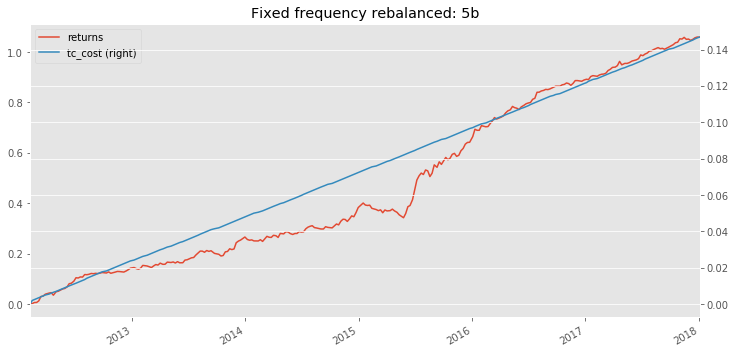

In [6]:
"""
Predicting and re-balance phase
"""

factor_groups = const_model_factor_data.groupby('trade_date')

for weight_gap in weight_gaps:
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[total_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for i, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i],
                                           upper_bound=risk_target[i])
            elif name == 'SIZE':
                base_target = abs(risk_target[i])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] + base_target * size_risk_lower,
                                           upper_bound=risk_target[i] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] * industry_lower,
                                           upper_bound=risk_target[i] * industry_upper)

        factor_values = factor_processing(total_data[const_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)

        # linear regression model
        models = models_series[models_series.index <= date]
        if models.empty:
            continue

        index_dates.append(date)
        model = models[-1]

        # x = predict_x[date]
        x = factor_processing(total_data[linear_model_features_keys].values,
                              pre_process=[winsorize_normal, standardize],
                              risk_factors=risk_exp,
                              post_process=[winsorize_normal, standardize])
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': total_data.code.values})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values

        if er2.std() > 0.:
            print("using alpha model")

        er = er1 + er2

        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverage}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    ret_df.to_csv('d:/zz500.csv')

#     sharp_calc = MovingSharp(49)
#     drawdown_calc = MovingMaxDrawdown(49)
#     max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

#     res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

#     total_returns = 0.

#     for i, ret in enumerate(ret_df['ret_after_tc']):
#         date = ret_df.index[i]
#         total_returns += ret
#         sharp_calc.push({'ret': ret, 'riskFree': 0.})
#         drawdown_calc.push({'ret': ret})
#         max_drawdown_calc.push({'ret': ret})

#         res_df.loc[date, 'daily_return'] = ret
#         res_df.loc[date, 'cum_ret'] = total_returns
#         res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
#         res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
#         res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

#         if i < 10:
#             res_df.loc[date, 'sharp'] = 0.
#         else:
#             res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

#     res_df.to_csv('hs300_{0}.csv'.format(int(weight_gap * 100)))